# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
from glob import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [106]:
paths = glob('data/*movies*.csv')
paths

['data\\movies_submission.csv',
 'data\\movies_test.csv',
 'data\\movies_train.csv']

In [107]:
train, test = pd.read_csv(paths[2]), pd.read_csv(paths[1])

train.shape, test.shape

((600, 12), (243, 11))

In [108]:
# train과 test의 데이터를 출력해봅니다
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [109]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [111]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
train.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [113]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [114]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [115]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

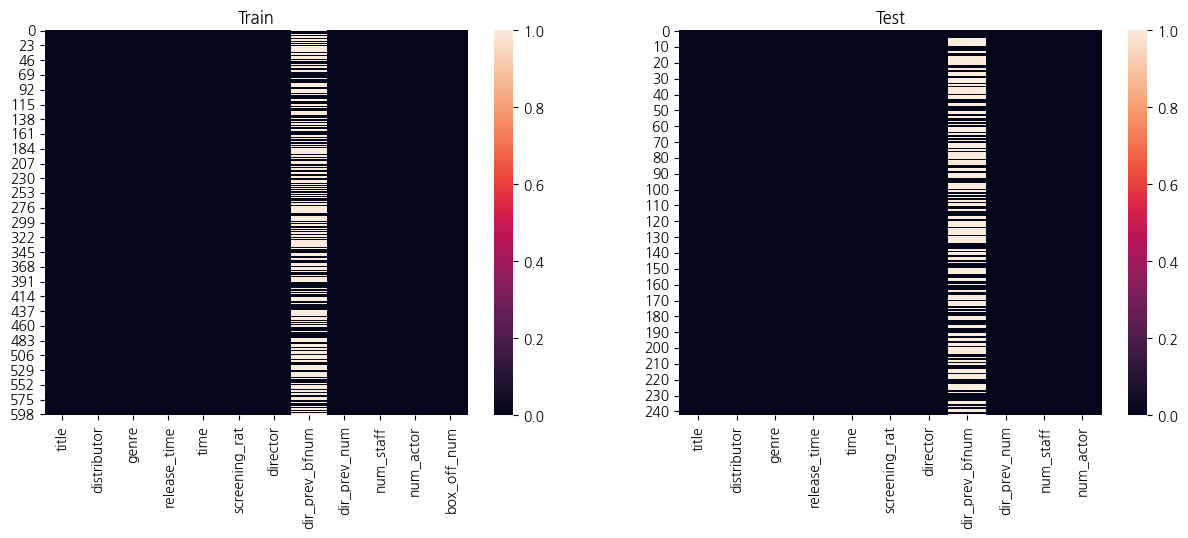

In [116]:
# 결측치를 시각화해봅니다
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

_ = sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train")
_ = sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

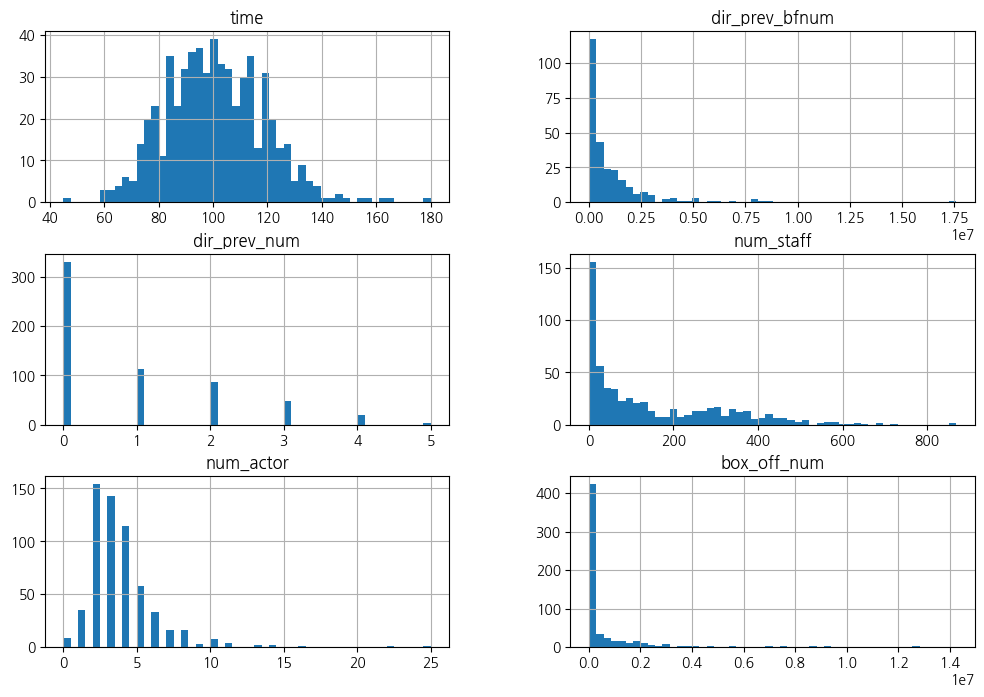

In [117]:
_ = train.hist(bins=50, figsize=(12, 8))

#### distributor: 배급사

In [118]:
# \(|주|\) 는 데이터에서 제거해줍니다
train["distributor"] = train["distributor"].str.replace("\(주\)", "")
test["distributor"] = test["distributor"].str.replace("\(주\)", "")

In [119]:
train['distributor'].unique()

array(['롯데엔터테인먼트', '쇼박스', 'NEW', '쇼박스미디어플렉스', '백두대간', '유니버설픽쳐스인터내셔널코리아',
       '두타연', ' 케이알씨지', '콘텐츠 윙', '키노아이', '팝 파트너스', 'CJ E&M 영화부문',
       ' 영화제작전원사', 'CJ E&M Pictures', 'CGV 무비꼴라쥬', '리틀빅픽처스', '스폰지',
       'CJ 엔터테인먼트', 'CGV아트하우스', '조이앤시네마', '인디플러그', '콘텐츠판다', '인디스토리',
       '팝엔터테인먼트', '시네마서비스', '웃기씨네', '영화사 진진', '레인보우 팩토리', '김기덕 필름',
       'CJ CGV', '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '마운틴픽쳐스', 'CGV 아트하우스',
       '메가박스플러스엠', '골든타이드픽처스', '파이오니아21', '디 씨드', '드림팩트 엔터테인먼트', '시너지',
       '디마엔터테인먼트', '판다미디어', '스톰픽쳐스코리아', '예지림 엔터테인먼트', ' 영화사조제',
       '보람엔터테인먼트', '시네마달', '노바엔터테인먼트', '패스파인더씨앤씨', '대명문화공장', '온비즈넷',
       'KT&G 상상마당', '무비꼴라쥬', '인벤트 디', '씨네그루키다리이엔티', '스튜디오후크', '시네마 달',
       '나이너스엔터테인먼트', 'THE 픽쳐스', '영구아트무비', '리틀빅픽쳐스', '어뮤즈', '이모션 픽처스',
       '이스트스카이필름', '필라멘트 픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹', '마운틴 픽처스',
       '휘엔터테인먼트', '이십세기폭스코리아', '피터팬픽쳐스', '에스와이코마드', '더픽쳐스', '오퍼스픽쳐스',
       '고앤고 필름', '사람과 사람들', 'JK필름', '씨너스엔터테인먼트', 'KT', '싸이더스FNH',
       '프레인글로벌', '나우콘텐츠', '홀리가든', 

In [120]:
test['distributor'].unique()

array(['시네마서비스', '쇼박스', 'CJ 엔터테인먼트', '모쿠슈라', '시네마 달', '루믹스미디어', '마운틴픽쳐스',
       '롯데쇼핑롯데엔터테인먼트', '싸이더스', '시너지', '노근리 프로덕션', 'KT&G 상상마당', '롯데엔터테인먼트',
       '키노아이', '쇼박스미디어플렉스', '리얼라이즈픽쳐스', '스폰지이엔티', '위드시네마', '청년필름', 'NEW',
       '인디스토리', '리아코어콘텐츠', '스토리셋', ' 영화사조제', '씨네굿필름', '영화사 진진', '어뮤즈',
       '핑크로봇 필름', 'Cinema SAM', '필라멘트 픽쳐스', '갑종필름', '필마픽쳐스', '크리에이티브컴즈',
       'CJ E&M Pictures', '오픈유컬쳐', '웃기씨네', '드림웨스트픽쳐스', '골든타이드픽처스',
       ' 액티버스엔터테인먼트', '씨너스엔터테인먼트', 'SBS콘텐츠허브', '타임스토리그룹', '팝엔터테인먼트',
       '시네마달', '미로비젼', '나이너스엔터테인먼트', '명필름', '두타연', ' 영화제작전원사', '무비꼴라쥬',
       '인벤트 디', '프리비젼', '미디어데이', '굿픽처스', '레몬트리', '타임스토리', '노바엔터테인먼트',
       '인디플러그', '영화사 빅', '유나이티드 픽처스', '(유)영화사 화수분', 'BoXoo 엔터테인먼트',
       '늘푸른시네마', '디씨드', ' 케이알씨지', '노버스엔터테인먼트', '드림로드', '씨네그루키다리이엔티',
       '루스이소니도스', '에이원 엔터테인먼트', '애니메이션 배급', '마인스 엔터테인먼트', '이십세기폭스코리아',
       '트리필름', 'CGV아트하우스', '와우픽쳐스', '하준사', '오퍼스픽쳐스', '메가박스중앙플러스엠',
       '리틀빅픽처스', '미디어로그', '메가박스플러스엠', '엣나인필름', '예지림 엔터테인먼트', '비에이치제이 시네마',
     

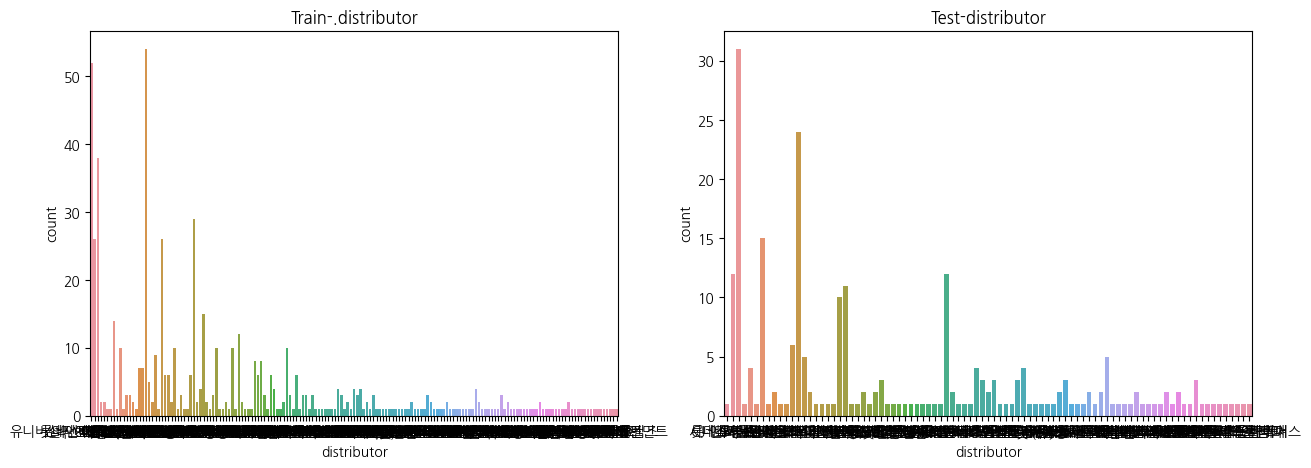

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

_ = sns.countplot(train.distributor, ax=ax[0]).set_title("Train-.distributor")
_ = sns.countplot(test.distributor, ax=ax[1]).set_title("Test-distributor")

In [122]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

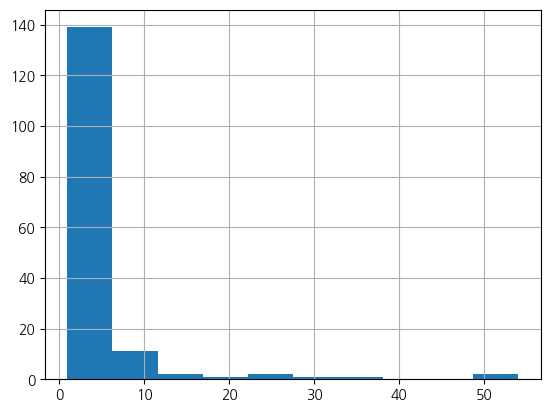

In [123]:
_ = train["distributor"].value_counts().hist()

ㅠㅠ.. 살려주세요

In [124]:
train["distributor"]

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598     CJ엔터테인먼트
599     CJ엔터테인먼트
Name: distributor, Length: 600, dtype: object

In [125]:
train["distributor"].value_counts()['JK필름']

1

In [126]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다

df = train['distributor'].value_counts() > 15
df = df[df == True].index.to_list()
    
def distributor_band(x):
    if x in df:
        return '중대형'
    else:
        return '소형'

In [127]:
train["distributor"] = train["distributor"].apply( distributor_band)
train["distributor"].value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [128]:
# 위 함수를 train과 test에 모두 적용합니다
test["distributor"] = test["distributor"].apply( distributor_band)
test["distributor"].value_counts()

소형     133
중대형    110
Name: distributor, dtype: int64

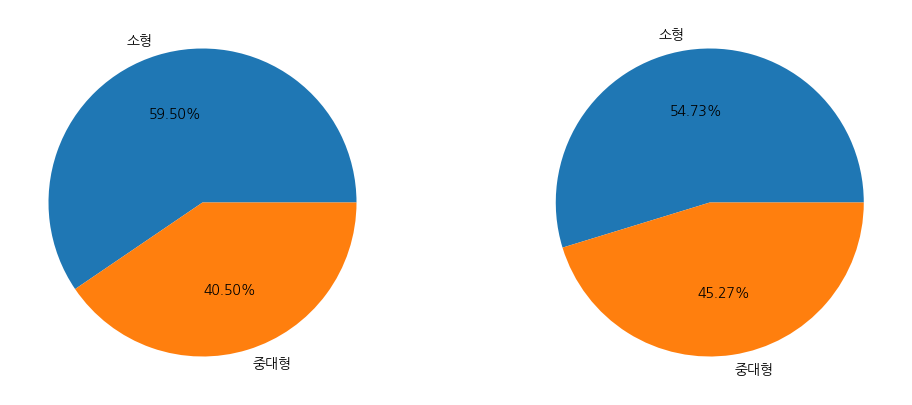

In [129]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [130]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [131]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12}


In [132]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [133]:
# 인코딩 전의 장르 컬럼은 버려줍니다
del train["genre"]
del test["genre"]

### release_time: 개봉일

In [134]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

In [135]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train['day'] = train['release_time'].dt.day
train['dayofweek'] = train['release_time'].dt.dayofweek

test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month
test['day'] = test['release_time'].dt.day
test['dayofweek'] = test['release_time'].dt.dayofweek

In [136]:
# 기존 데이터는 삭제합니다
del test['release_time']
del train['release_time']

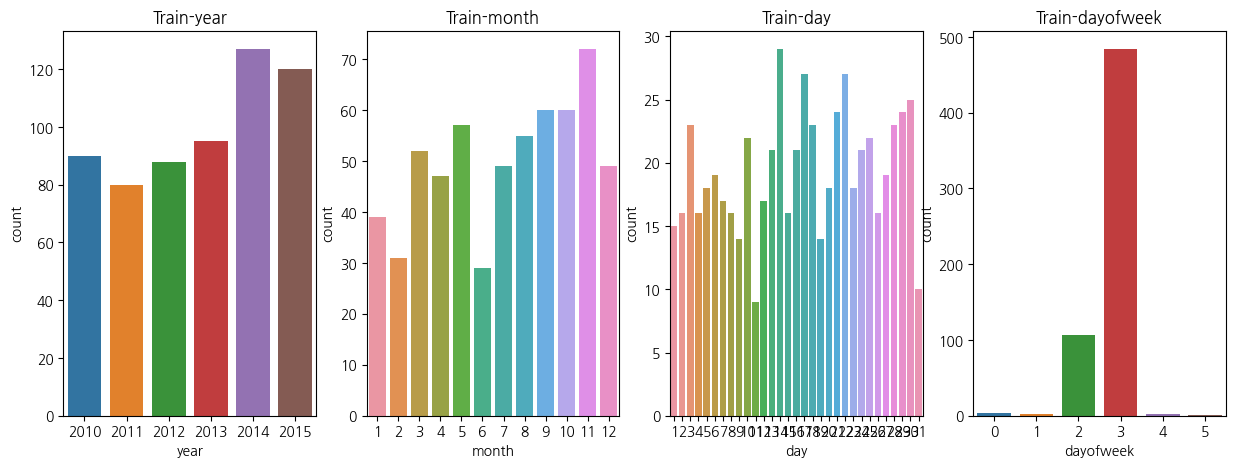

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

_ = sns.countplot(train.year, ax=ax[0]).set_title("Train-year")
_ = sns.countplot(train.month, ax=ax[1]).set_title("Train-month")
_ = sns.countplot(train.day, ax=ax[2]).set_title("Train-day")
_ = sns.countplot(train.dayofweek, ax=ax[3]).set_title("Train-dayofweek")

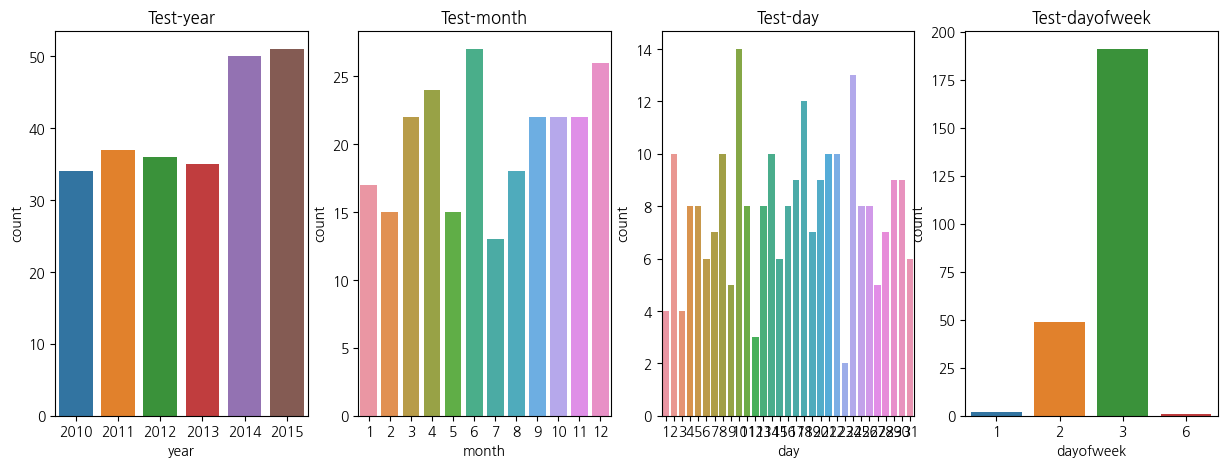

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

_ = sns.countplot(test.year, ax=ax[0]).set_title("Test-year")
_ = sns.countplot(test.month, ax=ax[1]).set_title("Test-month")
_ = sns.countplot(test.day, ax=ax[2]).set_title("Test-day")
_ = sns.countplot(test.dayofweek, ax=ax[3]).set_title("Test-dayofweek")

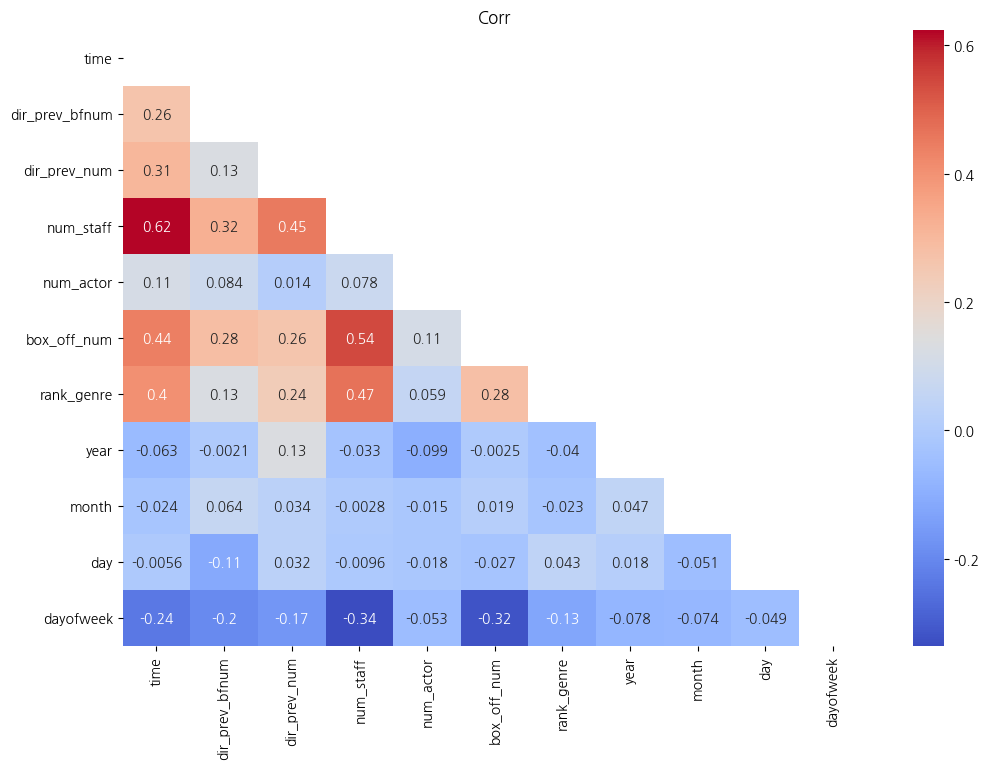

In [139]:
plt.figure(figsize=(12, 8))
_ = sns.heatmap(train.corr(), cmap="coolwarm", annot=True, mask=np.triu(np.ones_like(train.corr()))).set_title("Corr")

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [140]:
# 제목과 감독 데이터는 버려줍니다
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   time            600 non-null    int64  
 3   screening_rat   600 non-null    object 
 4   director        600 non-null    object 
 5   dir_prev_bfnum  270 non-null    float64
 6   dir_prev_num    600 non-null    int64  
 7   num_staff       600 non-null    int64  
 8   num_actor       600 non-null    int64  
 9   box_off_num     600 non-null    int64  
 10  rank_genre      600 non-null    int64  
 11  year            600 non-null    int64  
 12  month           600 non-null    int64  
 13  day             600 non-null    int64  
 14  dayofweek       600 non-null    int64  
dtypes: float64(1), int64(10), object(4)
memory usage: 70.4+ KB


In [141]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(['title', 'director'], axis=1)
test = test.drop(['title', 'director'], axis=1)

In [142]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [143]:
train.columns

Index(['distributor', 'time', 'screening_rat', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'rank_genre',
       'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [144]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [145]:
# 피처와 라벨을 구합니다
features_name = set(train.columns) - set(['box_off_num','dayofweek'])
label = 'box_off_num'

features = features_name
features

{'day',
 'dir_prev_bfnum',
 'dir_prev_num',
 'distributor_소형',
 'distributor_중대형',
 'month',
 'num_actor',
 'num_staff',
 'rank_genre',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가',
 'time',
 'year'}

### Log Scale

In [146]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train['num_actor'] = np.log1p(train['num_actor'])

In [147]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 15)
y_train: (510,)
X_val: (90, 15)
y_val: (90,)


In [148]:
test.shape

(243, 16)

### Random Forest

In [149]:
train['dir_prev_bfnum']

0            0.00
1      1161602.50
2       220775.25
3        23894.00
4            1.00
          ...    
595       3833.00
596     496061.00
597          0.00
598          0.00
599          0.00
Name: dir_prev_bfnum, Length: 600, dtype: float64

In [150]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

rmse: 1377636.6138653848

In [151]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1644103.5502987173

<AxesSubplot:>

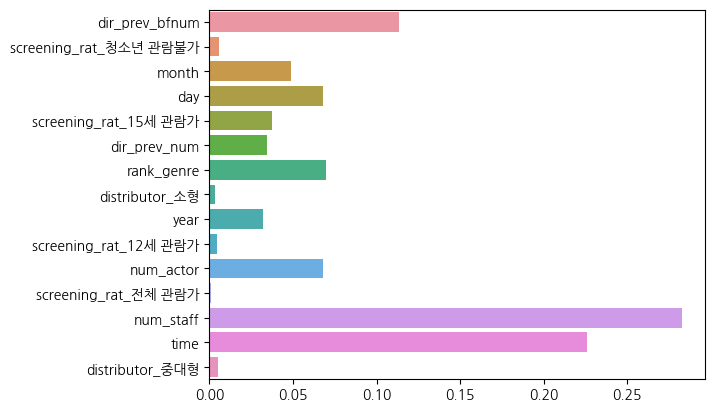

In [152]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

### XGBoost

In [153]:
model = XGBRegressor(n_jobs=-1,random_state=42)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1575075.0565565452

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

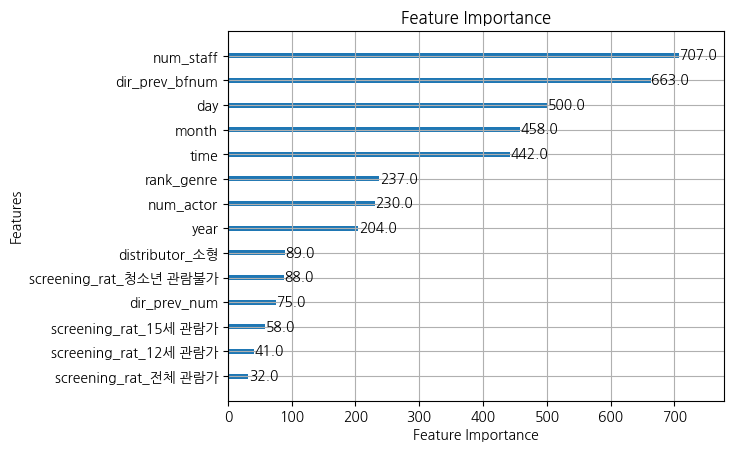

In [154]:
ax = xgb.plot_importance(model, max_num_features=len(features))
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features')

### LightGBM

In [155]:
model = LGBMRegressor(n_jobs=-1,random_state=42)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1677616.142854728

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

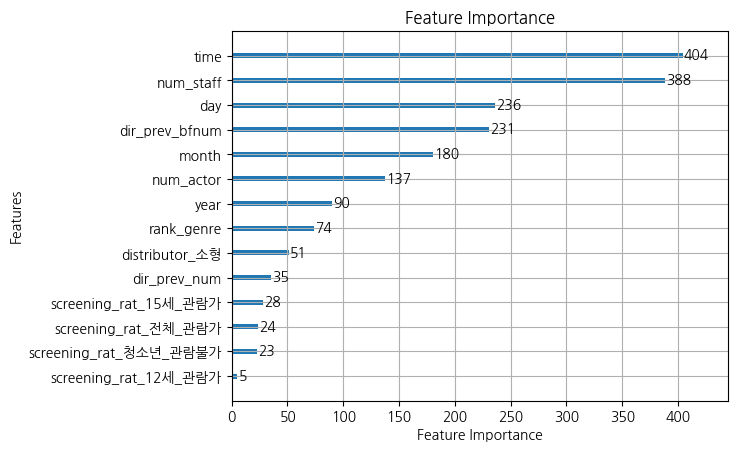

In [156]:
ax = lgbm.plot_importance(model, max_num_features=len(features), importance_type='auto')
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features')

- lightgbm 이 가장 점수가 좋게 나왔다